In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit , prange
from matplotlib.colors import TwoSlopeNorm
import progressbar
import hints
from itertools import permutations
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib.ticker import AutoMinorLocator
from scipy.io import loadmat
import glob
import imageio.v2 as imageio
import scipy
from statsmodels.tsa.stattools import adfuller
import Abolfazl as ab
import emd
from numba import njit
from numba_progress import ProgressBar
import thesis 
import time
from pdf2image import convert_from_path
from PIL import Image

## G

In [2]:

path='/Users/....'


def ReadEU7():
    folder="Synchronised measurements/"
    FIN_AU = pd.read_csv(folder+'finland_AU.csv.zip', index_col=0)
    FIN_TTY = pd.read_csv(folder+'finland_TTY.csv.zip', index_col=0)
    NOR_NTUN = pd.read_csv(folder+'norway_NTNU.csv.zip', index_col=0)
    SWE_CTH = pd.read_csv(folder+'sweden_CTH.csv.zip', index_col=0)
    SWE_KTH = pd.read_csv(folder+'sweden_KTH.csv.zip', index_col=0)
    SWE_LTH = pd.read_csv(folder+'sweden_LTH.csv.zip', index_col=0)
    SWE_LTU = pd.read_csv(folder+'sweden_LTU.csv.zip', index_col=0)

    FIN_AU['date']=FIN_AU.index
    FIN_TTY['date']=FIN_TTY.index
    NOR_NTUN['date']=NOR_NTUN.index
    SWE_CTH['date']=SWE_CTH.index
    SWE_KTH['date']=SWE_KTH.index
    SWE_LTH['date']=SWE_LTH.index
    SWE_LTU['date']=SWE_LTU.index


    FIN_AU.rename(columns = {'Frequency':'FIN_AU'}, inplace = True)
    FIN_TTY.rename(columns = {'Frequency':'FIN_TTY'}, inplace = True)
    NOR_NTUN.rename(columns = {'Frequency':'NOR_NTUN'}, inplace = True)
    SWE_CTH.rename(columns = {'Frequency':'SWE_CTH'}, inplace = True)
    SWE_KTH.rename(columns = {'Frequency':'SWE_KTH'}, inplace = True)
    SWE_LTH.rename(columns = {'Frequency':'SWE_LTH'}, inplace = True)
    SWE_LTU.rename(columns = {'Frequency':'SWE_LTU'}, inplace = True)

    FIN_AU=FIN_AU[['date',"FIN_AU"]]
    FIN_TTY=FIN_TTY[['date',"FIN_TTY"]]
    NOR_NTUN=NOR_NTUN[['date',"NOR_NTUN"]]
    SWE_CTH=SWE_CTH[['date',"SWE_CTH"]]
    SWE_KTH=SWE_KTH[['date',"SWE_KTH"]]
    SWE_LTH=SWE_LTH[['date',"SWE_LTH"]]
    SWE_LTU=SWE_LTU[['date',"SWE_LTU"]]

    FIN_AU.reset_index(drop=True, inplace=True)
    FIN_TTY.reset_index(drop=True, inplace=True)
    NOR_NTUN.reset_index(drop=True, inplace=True)
    SWE_CTH.reset_index(drop=True, inplace=True)
    SWE_KTH.reset_index(drop=True, inplace=True)
    SWE_LTH.reset_index(drop=True, inplace=True)
    SWE_LTU.reset_index(drop=True, inplace=True)

    EU7 = pd.merge(FIN_AU, FIN_TTY, on='date', how='inner')
    EU7 = pd.merge(EU7, NOR_NTUN, on='date', how='inner')
    EU7 = pd.merge(EU7, SWE_CTH, on='date', how='inner')
    EU7 = pd.merge(EU7, SWE_KTH, on='date', how='inner')
    EU7 = pd.merge(EU7, SWE_LTH, on='date', how='inner')
    EU7 = pd.merge(EU7, SWE_LTU, on='date', how='inner')

    dates = EU7['date']

    EU7.drop('date',inplace=True,axis=1)
    EU7=EU7.to_numpy()
    EU7=np.swapaxes(EU7,0,1)

    cols_with_nan = np.isnan(EU7).any(axis=0)
    EU7 = EU7[:, ~cols_with_nan]

    np.save(folder+"EU7.npy",EU7)
    dates.to_csv(folder+"EU7_dates.csv", index=False)

def LoadEU7():
    folder="Synchronised measurements/"
    EU7=np.load(folder+"EU7.npy")
    dates = pd.read_csv(folder+"EU7_dates.csv")
    dates['date'] = pd.to_datetime(dates['date']) 
    npdates=dates['date'].dt.strftime('%Y-%m-%d %H:%M:%S').to_numpy()     # .%f    
    return EU7, dates, npdates 

@njit(parallel=True)
def localnorm( nl, data):
    newdata=np.zeros((data.shape[0],int(data.shape[1]-nl)))
    for i in prange(data.shape[0]):
        for j in range(nl, data.shape[1]):  
            newdata[i,j-nl] = (data[i,j] - np.mean(data[i,j-nl:j])) / np.std(data[i,j-nl:j])
    return newdata


def KMC_ABC(x,dt,N,M,mode,method):
    
    # if method=='abolfazl':
    #     x, y = caly(x, N)
    #     Dcoeffs, ind, col = calD1coef(x, y, dt, N, M, mode)
    # elif method=='hints':
    #     calulator = hints.kmcc(ts_array=np.swapaxes(x,0,1), dt=dt, interaction_order=M, estimation_mode='drift')
    #     Dcoeffs = calulator.get_coefficients()  
    # elif method=='hints2' or method=='amin':   
    #     Dcoeffs = kmc(np.swapaxes(x,0,1), dt=dt, order=[1,2,3], mode='drift', **{'window_order':5, 'solver':'both', 'threshold':1e-15})   # 0
    # else:
    #     raise ValueError("Method options are: 'abolfazl', 'hints', 'hints2' ")

    calulator = hints.kmcc(ts_array=np.swapaxes(x,0,1), dt=dt, interaction_order=M, estimation_mode='drift')
    Dcoeffs = calulator.get_coefficients()  
    Dcoeffs = np.swapaxes(Dcoeffs.to_numpy(), 0, 1)

    Constant = np.zeros(N)
    A = np.zeros((N, N))        
    B = np.zeros((N, N, N))    
    C = np.zeros((N, N, N, N))  

    
    num_first_order = N
    num_second_order = int(N * (N + 1) / 2)
    num_third_order = int(N * (N + 1) * (N + 2) / 6)

    
    if 0 in M:  
        Constant[:] = Dcoeffs[:, 0]
        A[:, :] = Dcoeffs[:, 1:N+1]  
    else:
        A[:, :] = Dcoeffs[:, :N]     
    
    
    if 2 in M:  
        if 0 in M:
            counter = num_first_order + 1
        else:    
            counter = num_first_order
        for i in range(N):
            for j in range(i, N):
                for idx in set(permutations((i, j))): B[:, idx[0], idx[1]] = Dcoeffs[:, counter]
                counter += 1

    if 3 in M:  
        if 0 in M:
            counter = num_first_order + num_second_order + 1
        else:
            counter = num_first_order + num_second_order
        for i in range(N):
            for j in range(i, N):
                for k in range(j, N):
                    for idx in set(permutations((i, j, k))): C[:, idx[0], idx[1], idx[2]] = Dcoeffs[:, counter]
                    counter += 1

    return Constant, A, B, C, Dcoeffs

def KMC_ABC_overtime(data,win,ol,N,M,mode,dt,tstart,zmean,uvar,method):
    dx=win*(100-ol)/100
    n_win=int((data.shape[1]-win)/dx+1)
    alleval=[]
    allevec=[]
    allcons=np.zeros((n_win,N))
    alla=np.zeros((n_win,N,N))
    allb=np.zeros((n_win,N,N,N))
    allc=np.zeros((n_win,N,N,N,N))
    alldcoefllist=[]
    t=int(win/2+tstart)
    tlist=[]
    ii=0
    tarray=np.arange(int(win / 2 + tstart), int(data.shape[1] - win / 2), dx)

    # bar = progressbar.ProgressBar(maxval=len(tarray),  redirect_stdout=True,  redirect_stderr=True, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    # bar.start()


    for t in tarray:
        tlist.append(t)
        start=int(t-win/2)
        end=int(t+win/2)
        x=np.zeros((N,win))
        x[:,:]=data[:,start:end]

        for i in range(N):
            if zmean==True:
                x[i,:]=x[i,:]-np.mean(x[i,:])
            if uvar==True:
                x[i,:]=x[i,:]/np.std(x[i,:])

        # # removeoutlier
        # xlims = np.array([[-3*np.std(x[i,:]), 3*np.std(x[i,:])] for i in range(N)])
        # for i in range(N):
        #     for j in range(win):
        #         # zero
        #         if x[i,j]>xlims[i,1] or x[i,j]<xlims[i,0]:
        #             x[i,j]=0  
        #         # mean
        #         # if x[i,j]>xlims[i,1] or x[i,j]<xlims[i,0]:
        #         #     x[i,j]=(x[i,j-1]+x[i,j+1])/2              

        cons, A, B, C, Dcoeffs=KMC_ABC(x,dt,N,M,mode,method)
        allcons[ii,:]=cons[:]
        alla[ii,:,:]=A[:,:]
        allb[ii,:,:,:]=B[:,:,:]
        allc[ii,:,:,:,:]=C[:,:,:,:]
        alldcoefllist.append(Dcoeffs)
        
        w, v = np.linalg.eig(A)
        alleval.append(w)
        allevec.append(v)
        ii+=1
    #     bar.update(ii)
    # bar.finish()

    alldcoefllist=np.array(alldcoefllist)
    alleval=np.array(alleval)
    allevec=np.array(allevec)


    return tlist, allcons, alla, allb, allc, alldcoefllist, alleval, allevec

@njit( parallel=True) 
def stationarycheck(x,smin,smax,ds):
    sigmamean=np.zeros((smax-smin)//ds)
    sigmaerror=np.zeros((smax-smin)//ds)
    steps=len(x)
    for s in range(smin,smax,ds):
        ndx=steps//s
        sigma=np.zeros(ndx)
        for i in range(ndx):
            sigma[i]=np.std(x[(i)*s:s*(i+1)])
        sigmamean[(s-smin)//ds]=np.mean(sigma)
        sigmaerror[(s-smin)//ds]=np.std(sigma)/np.sqrt(ndx)
    return sigmamean,sigmaerror

@njit()
def removeoutlier(method,xlims,x):
    xx = np.copy(x)
    if method=="zero":
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if xx[i,j]>xlims[i,1] or xx[i,j]<xlims[i,0]:
                    xx[i,j]=0
    elif method=="mean":
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if xx[i,j]>xlims[i,1] or xx[i,j]<xlims[i,0]:
                    xx[i,j]=(xx[i,j-1]+xx[i,j+1])/2
    return xx

@njit(parallel=True)
def pdfkernel(data,pdflen,xlim=[0,0]):
    pdf=np.zeros(pdflen) 
    if xlim==[0,0]:
        xmin=np.min(data)
        xmax=np.max(data)
        xline=np.linspace(xmin,xmax,pdflen)
    else:
        xmin=xlim[0]
        xmax=xlim[1]
        xline=np.linspace(xmin,xmax,pdflen)
    dx=(xmax-xmin)/pdflen
    h=len(data)**(-1/5)
    for j in prange(1,pdflen+1):
        print(j)
        fksum=0
        for i in range(len(data)):
            xi=data[i]
            xj=(j-0.5)*dx+xmin
            fksum=fksum+np.exp(-0.5*((xi-xj)/h)**2)
        pdf[j-1]=(1/(len(data)*h))*(1/np.sqrt(2*pi))*fksum

    return pdf,xline

@njit
def pdfbin(data,bin,xlim=[0,0]):
    if xlim==[0,0]:
        xmin=np.min(data)
        xmax=np.max(data)
        xline=np.linspace(xmin,xmax,bin)
    else:
        xmin=xlim[0]
        xmax=xlim[1]
        xline=np.linspace(xmin,xmax,bin) 
    dx=(xmax-xmin)/bin  
    pdf=np.zeros(bin)
    binarray=np.arange(bin)
    
    for i in range(len(data)):
        bin=int((data[i]-xmin)/dx)
        #print(bin)
        if bin in binarray:pdf[bin]+=1    
    return pdf,xline

@njit
def MY_EM_SDE(N,F,G,Ksi,dt,nsteps,x0):
    x = np.zeros((N,nsteps))
    dw=np.random.normal(0, 1, (N,nsteps)) * np.sqrt(dt)
    x[:,0]=x0
    for i in range(nsteps - 1):
        x[:,i + 1] = x[:,i] + F(x[:,i],i*dt)*dt +  np.dot(G(x[:,i],i*dt) , dw[:,i]) + Ksi(x[:,i],i*dt) 
    return x  

@njit
def L96F(x,t):
    N=len(x)
    Fcoef = 1
    F = np.zeros(N)
    for i in range(N):
        F[i] = (x[(i+1) % N] - x[i-2]) * x[i-1] - x[i] + Fcoef
    return F

@njit
def L96G(x, t):
    N=len(x)
    G=np.zeros((N,N))
    for i in range(N):
        G[i,i] = 0.02 + 0*x[i]
    return G

@njit
def L96Ksi(x, t):
    N=len(x)
    KKSSII=np.zeros(N)
    return KKSSII

def ReadEU7():
    folder="Synchronised measurements/"
    FIN_AU = pd.read_csv(folder+'finland_AU.csv.zip', index_col=0)
    FIN_TTY = pd.read_csv(folder+'finland_TTY.csv.zip', index_col=0)
    NOR_NTUN = pd.read_csv(folder+'norway_NTNU.csv.zip', index_col=0)
    SWE_CTH = pd.read_csv(folder+'sweden_CTH.csv.zip', index_col=0)
    SWE_KTH = pd.read_csv(folder+'sweden_KTH.csv.zip', index_col=0)
    SWE_LTH = pd.read_csv(folder+'sweden_LTH.csv.zip', index_col=0)
    SWE_LTU = pd.read_csv(folder+'sweden_LTU.csv.zip', index_col=0)

    FIN_AU['date']=FIN_AU.index
    FIN_TTY['date']=FIN_TTY.index
    NOR_NTUN['date']=NOR_NTUN.index
    SWE_CTH['date']=SWE_CTH.index
    SWE_KTH['date']=SWE_KTH.index
    SWE_LTH['date']=SWE_LTH.index
    SWE_LTU['date']=SWE_LTU.index


    FIN_AU.rename(columns = {'Frequency':'FIN_AU'}, inplace = True)
    FIN_TTY.rename(columns = {'Frequency':'FIN_TTY'}, inplace = True)
    NOR_NTUN.rename(columns = {'Frequency':'NOR_NTUN'}, inplace = True)
    SWE_CTH.rename(columns = {'Frequency':'SWE_CTH'}, inplace = True)
    SWE_KTH.rename(columns = {'Frequency':'SWE_KTH'}, inplace = True)
    SWE_LTH.rename(columns = {'Frequency':'SWE_LTH'}, inplace = True)
    SWE_LTU.rename(columns = {'Frequency':'SWE_LTU'}, inplace = True)

    FIN_AU=FIN_AU[['date',"FIN_AU"]]
    FIN_TTY=FIN_TTY[['date',"FIN_TTY"]]
    NOR_NTUN=NOR_NTUN[['date',"NOR_NTUN"]]
    SWE_CTH=SWE_CTH[['date',"SWE_CTH"]]
    SWE_KTH=SWE_KTH[['date',"SWE_KTH"]]
    SWE_LTH=SWE_LTH[['date',"SWE_LTH"]]
    SWE_LTU=SWE_LTU[['date',"SWE_LTU"]]

    FIN_AU.reset_index(drop=True, inplace=True)
    FIN_TTY.reset_index(drop=True, inplace=True)
    NOR_NTUN.reset_index(drop=True, inplace=True)
    SWE_CTH.reset_index(drop=True, inplace=True)
    SWE_KTH.reset_index(drop=True, inplace=True)
    SWE_LTH.reset_index(drop=True, inplace=True)
    SWE_LTU.reset_index(drop=True, inplace=True)

    EU7 = pd.merge(FIN_AU, FIN_TTY, on='date', how='inner')
    EU7 = pd.merge(EU7, NOR_NTUN, on='date', how='inner')
    EU7 = pd.merge(EU7, SWE_CTH, on='date', how='inner')
    EU7 = pd.merge(EU7, SWE_KTH, on='date', how='inner')
    EU7 = pd.merge(EU7, SWE_LTH, on='date', how='inner')
    EU7 = pd.merge(EU7, SWE_LTU, on='date', how='inner')

    dates = EU7['date']

    EU7.drop('date',inplace=True,axis=1)
    EU7=EU7.to_numpy()
    EU7=np.swapaxes(EU7,0,1)

    cols_with_nan = np.isnan(EU7).any(axis=0)
    EU7 = EU7[:, ~cols_with_nan]

    np.save(folder+"EU7.npy",EU7)
    dates.to_csv(folder+"EU7_dates.csv", index=False)

def LoadEU7():
    folder="Synchronised measurements/"
    EU7=np.load(folder+"EU7.npy")
    dates = pd.read_csv(folder+"EU7_dates.csv")
    dates['date'] = pd.to_datetime(dates['date']) 
    npdates=dates['date'].dt.strftime('%Y-%m-%d %H:%M:%S').to_numpy()     # .%f    
    return EU7, dates, npdates 

@njit(parallel=True)
def localnorm( nl, data):
    newdata=np.zeros((data.shape[0],int(data.shape[1]-nl)))
    for i in prange(data.shape[0]):
        for j in range(nl, data.shape[1]):  
            newdata[i,j-nl] = (data[i,j] - np.mean(data[i,j-nl:j])) / np.std(data[i,j-nl:j])
    return newdata

def KMC_ABC(x,dt,N,M,mode,method):
    
    # if method=='abolfazl':
    #     x, y = caly(x, N)
    #     Dcoeffs, ind, col = calD1coef(x, y, dt, N, M, mode)
    # elif method=='hints':
    #     calulator = hints.kmcc(ts_array=np.swapaxes(x,0,1), dt=dt, interaction_order=M, estimation_mode='drift')
    #     Dcoeffs = calulator.get_coefficients()  
    # elif method=='hints2' or method=='amin':   
    #     Dcoeffs = kmc(np.swapaxes(x,0,1), dt=dt, order=[1,2,3], mode='drift', **{'window_order':5, 'solver':'both', 'threshold':1e-15})   # 0
    # else:
    #     raise ValueError("Method options are: 'abolfazl', 'hints', 'hints2' ")

    calulator = hints.kmcc(ts_array=np.swapaxes(x,0,1), dt=dt, interaction_order=M, estimation_mode='drift')
    Dcoeffs = calulator.get_coefficients()  
    Dcoeffs = np.swapaxes(Dcoeffs.to_numpy(), 0, 1)

    Constant = np.zeros(N)
    A = np.zeros((N, N))        
    B = np.zeros((N, N, N))    
    C = np.zeros((N, N, N, N))  

    
    num_first_order = N
    num_second_order = int(N * (N + 1) / 2)
    num_third_order = int(N * (N + 1) * (N + 2) / 6)

    
    if 0 in M:  
        Constant[:] = Dcoeffs[:, 0]
        A[:, :] = Dcoeffs[:, 1:N+1]  
    else:
        A[:, :] = Dcoeffs[:, :N]     
    
    
    if 2 in M:  
        if 0 in M:
            counter = num_first_order + 1
        else:    
            counter = num_first_order
        for i in range(N):
            for j in range(i, N):
                for idx in set(permutations((i, j))): B[:, idx[0], idx[1]] = Dcoeffs[:, counter]
                counter += 1

    if 3 in M:  
        if 0 in M:
            counter = num_first_order + num_second_order + 1
        else:
            counter = num_first_order + num_second_order
        for i in range(N):
            for j in range(i, N):
                for k in range(j, N):
                    for idx in set(permutations((i, j, k))): C[:, idx[0], idx[1], idx[2]] = Dcoeffs[:, counter]
                    counter += 1

    return Constant, A, B, C, Dcoeffs

def KMC_ABC_overtime(data,win,ol,N,M,mode,dt,tstart,zmean,uvar,method):
    dx=win*(100-ol)/100
    n_win=int((data.shape[1]-win)/dx+1)
    alleval=[]
    allevec=[]
    allcons=np.zeros((n_win,N))
    alla=np.zeros((n_win,N,N))
    allb=np.zeros((n_win,N,N,N))
    allc=np.zeros((n_win,N,N,N,N))
    alldcoefllist=[]
    t=int(win/2+tstart)
    tlist=[]
    ii=0
    tarray=np.arange(int(win / 2 + tstart), int(data.shape[1] - win / 2), dx)

    # bar = progressbar.ProgressBar(maxval=len(tarray),  redirect_stdout=True,  redirect_stderr=True, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    # bar.start()


    for t in tarray:
        tlist.append(t)
        start=int(t-win/2)
        end=int(t+win/2)
        x=np.zeros((N,win))
        x[:,:]=data[:,start:end]

        for i in range(N):
            if zmean==True:
                x[i,:]=x[i,:]-np.mean(x[i,:])
            if uvar==True:
                x[i,:]=x[i,:]/np.std(x[i,:])

        cons, A, B, C, Dcoeffs=KMC_ABC(x,dt,N,M,mode,method)
        allcons[ii,:]=cons[:]
        alla[ii,:,:]=A[:,:]
        allb[ii,:,:,:]=B[:,:,:]
        allc[ii,:,:,:,:]=C[:,:,:,:]
        alldcoefllist.append(Dcoeffs)
        
        w, v = np.linalg.eig(A)
        alleval.append(w)
        allevec.append(v)
        ii+=1
    #     bar.update(ii)
    # bar.finish()

    alldcoefllist=np.array(alldcoefllist)
    alleval=np.array(alleval)
    allevec=np.array(allevec)


    return tlist, allcons, alla, allb, allc, alldcoefllist, alleval, allevec

@njit(parallel=True)
def pdfkernel(data,pdflen,xlim=[0,0]):
    pdf=np.zeros(pdflen) 
    if xlim==[0,0]:
        xmin=np.min(data)
        xmax=np.max(data)
        xline=np.linspace(xmin,xmax,pdflen)
    else:
        xmin=xlim[0]
        xmax=xlim[1]
        xline=np.linspace(xmin,xmax,pdflen)
    dx=(xmax-xmin)/pdflen
    h=len(data)**(-1/5)
    for j in prange(1,pdflen+1):
        print(j)
        fksum=0
        for i in range(len(data)):
            xi=data[i]
            xj=(j-0.5)*dx+xmin
            fksum=fksum+np.exp(-0.5*((xi-xj)/h)**2)
        pdf[j-1]=(1/(len(data)*h))*(1/np.sqrt(2*pi))*fksum

    return pdf,xline

@njit
def pdfbin(data,bin,xlim=[0,0]):
    if xlim==[0,0]:
        xmin=np.min(data)
        xmax=np.max(data)
        xline=np.linspace(xmin,xmax,bin)
    else:
        xmin=xlim[0]
        xmax=xlim[1]
        xline=np.linspace(xmin,xmax,bin) 
    dx=(xmax-xmin)/bin  
    pdf=np.zeros(bin)
    binarray=np.arange(bin)
    
    for i in range(len(data)):
        bin=int((data[i]-xmin)/dx)
        #print(bin)
        if bin in binarray:pdf[bin]+=1    
    return pdf,xline


nansa=20
tlist=[1,2,5,10,20,50,100,200,500,1000,2000,5000,10000]
dimenlist=[2,3,4,5,6,7,8,9,10]
mlist=[2,3,4,5]

dt=0.001
mode='lim'

# Load the data

In [ ]:
ReadEU7()
EU7, dates, npdates = LoadEU7()

EU7_ln1E1=localnorm(10, EU7)
EU7_ln1E2=localnorm(100, EU7)
EU7_ln1E3=localnorm(1000, EU7)
EU7_ln5E3=localnorm(5000, EU7)
EU7_ln1E4=localnorm(10000, EU7)
EU7_ln45E4=localnorm(45000, EU7)
EU7_ln9E4=localnorm(90000, EU7)

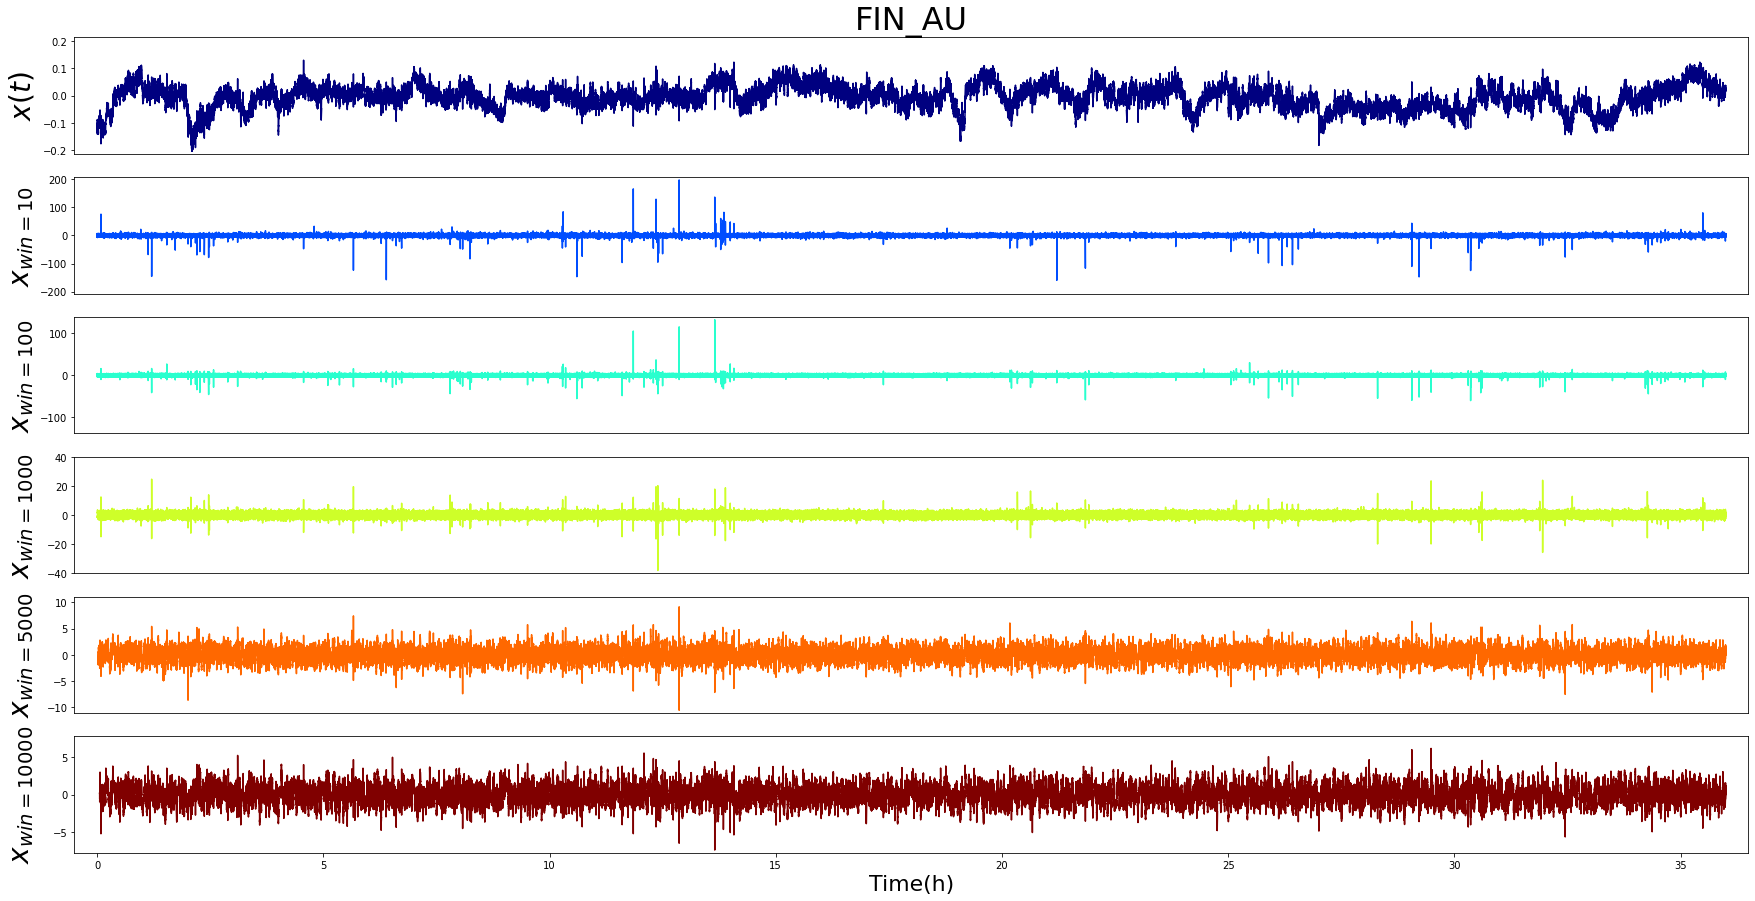

In [5]:
lab=[r'$x(t)$', r'$x_{win=10}$', r'$x_{win=100}$', r'$x_{win=1000}$', r'$x_{win=5000}$', r'$x_{win=10000}$']
position = ['FIN_AU', 'FIN_TTY', 'NOR_NTUN', 'SWE_CTH', 'SWE_KTH', 'SWE_LTH', 'SWE_LTU']
data = [EU7, EU7_ln1E1, EU7_ln1E2, EU7_ln1E3, EU7_ln5E3, EU7_ln1E4]
start_points = [0, 10, 100, 1000, 5000, 10000]


cmap = plt.get_cmap('jet', len(data)) 
fig = plt.figure(figsize=(30, 15))
main_gs = gridspec.GridSpec(len(data), 1, hspace=0.2, wspace=0.2)
axs = [fig.add_subplot(main_gs[i]) for i in range(len(data))]
i_dim=0
for i in range(len(data)):
    axs[i].set_ylabel(lab[i], fontsize=28)
    axs[i].set_xlim((-0.5, 36.5))
    axs[i].set_ylim( ( -np.max(abs(data[i][i_dim,:]))*1.05,np.max(abs(data[i][i_dim,:]))*1.05 ) )
    taxs = np.linspace(start_points[i]*0.02/3600,len(EU7[0])*0.02/3600, int(len(EU7[0])-start_points[i]) )
    axs[i].plot(taxs, data[i][i_dim,:], color = cmap(i / len(data)))
    
    if i!=int(len(data)-1):
        axs[i].xaxis.set_ticks([])
    if i==int(len(data)-1):    
        axs[i].set_xlabel('Time(h)', fontsize=22)

axs[0].set_title(position[i_dim], fontsize=32)
fig.align_ylabels(axs[:])
plt.show()

# Convergence of Moments

In [8]:
N=1
tlist=[500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000, 512000]
nansa = 20  
data = [EU7, EU7_ln1E1, EU7_ln1E2, EU7_ln1E3, EU7_ln5E3, EU7_ln1E4]

moments = np.zeros((len(data), len(tlist),nansa, 7, 5))
EU_counter=0
for x in data:
    for t in tlist:
        for n in range(nansa):
            xstart = np.random.randint(0, EU7.shape[1]-6*10**5)
            xend = int(xstart + t)
            for i in range(7):
                newdata=np.copy(x[i,xstart:xend].flatten())
                moments[EU_counter, tlist.index(t), n, i, 0] = np.mean(newdata**2) 
                moments[EU_counter, tlist.index(t), n, i, 1] = np.mean(newdata**4) 
                moments[EU_counter, tlist.index(t), n, i, 2] = np.mean(newdata**6) 
                moments[EU_counter, tlist.index(t), n, i, 3] = np.mean(newdata**8) 
                moments[EU_counter, tlist.index(t), n, i, 4] = np.mean(newdata**10) 
    EU_counter+=1

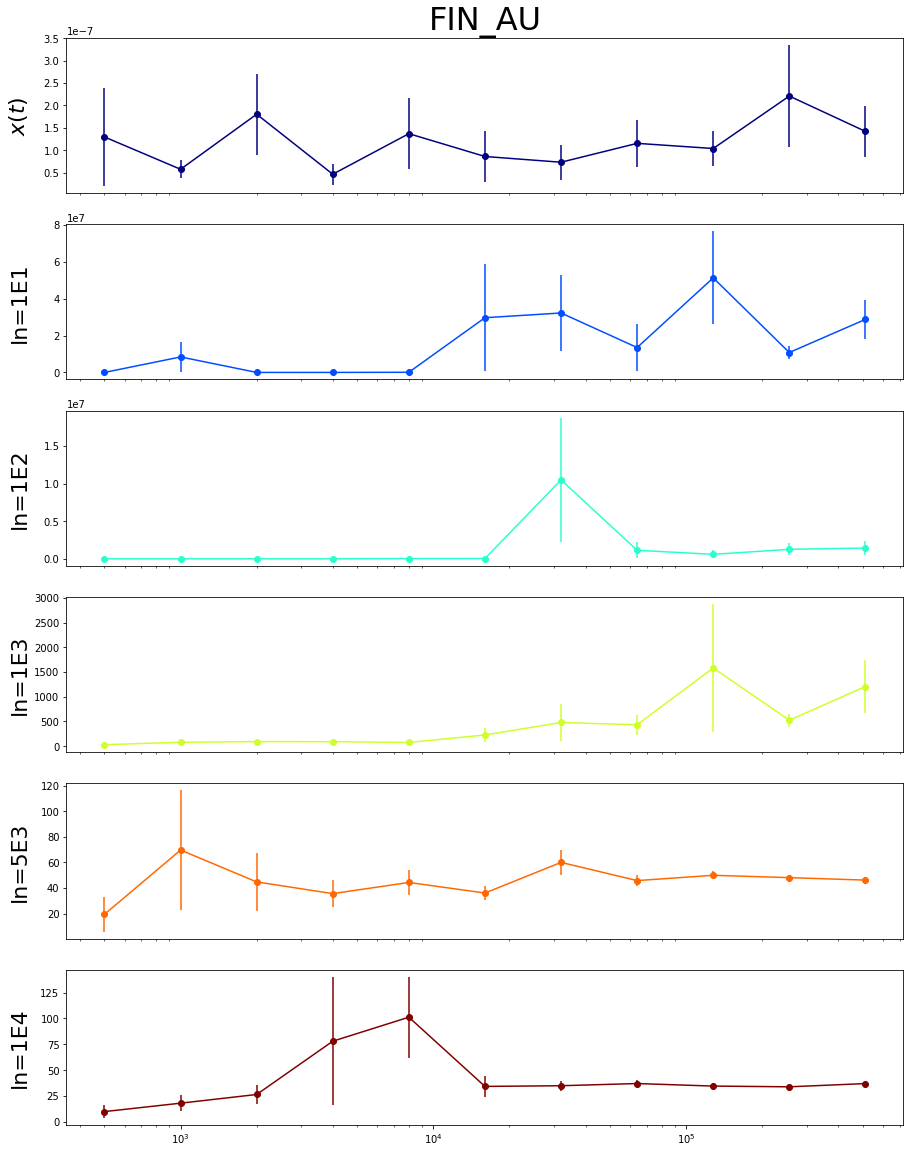

In [9]:
lab=[r'$x(t)$', 'ln=1E1', 'ln=1E2', 'ln=1E3', 'ln=5E3', 'ln=1E4']
position = ['FIN_AU', 'FIN_TTY', 'NOR_NTUN', 'SWE_CTH', 'SWE_KTH', 'SWE_LTH', 'SWE_LTU']


cmap = plt.get_cmap('jet', len(data)) 
fig = plt.figure(figsize=(15, 20))
main_gs = gridspec.GridSpec(len(data), 1, hspace=0.2, wspace=0.2)
axs = [fig.add_subplot(main_gs[i]) for i in range(len(data))]
i_dim=0
for i in range(len(data)):
    axs[i].set_ylabel(lab[i], fontsize=22)
    axs[i].errorbar(tlist, np.mean(moments[i, :, :, 0, 2], axis=1), yerr=np.std(moments[i, :, :, 0, 2], axis=1)/np.sqrt(nansa), fmt="o-", color=cmap(i,len(data)))
    axs[i].set_xscale('log')
    
    if i!=int(len(data)-1):
        axs[i].xaxis.set_ticks([])
axs[0].set_title(position[i_dim], fontsize=32)
    

fig.align_ylabels(axs[:])
plt.savefig('res/x6_moments.jpeg', dpi=300, bbox_inches='tight')
plt.show()

# Run the code

In [11]:
dt=0.02
N=7
M=[1,2,3]
mode='list'
win=540000
ol=95
tstart=0
zmean=True
uvar=True
method='hints'
tlist, allcons, alla, allb, allc, alldcoefllist, alleval, allevec=KMC_ABC_overtime(EU7_ln1E4,win,ol,N,M,mode,dt,tstart,zmean,uvar,method)

In [12]:
NumberOfStable_UnstableFixedPoints=np.loadtxt("res/alinew/NumberOfStable&UnstableFixedPoints.txt")   
ChosenStableFixedPointValues=np.loadtxt("res/alinew/ChosenStableFixedPointValues.txt")               
ChosenFixedPointRightMostEigenValueReal=np.loadtxt("res/alinew/ChosenFixedPointRightMostEigenValueReal.txt")   
ChosenFixedPointLeftMostEigenValueReal=np.loadtxt("res/alinew/ChosenFixedPointLeftMostEigenValueReal.txt")     

ChosenFixedPointAllEigenvalues = loadmat('res/alinew/ChosenFixedPointAllEigenvalues.mat')              
ChosenFixedPointAllEigenvalues=np.array(ChosenFixedPointAllEigenvalues["Expression1"])  

EffectiveAdjacency = loadmat('res/alinew/EffectiveAdjacency.mat')   
EffectiveAdjacency=np.array(EffectiveAdjacency["Expression1"])  

chosenFixedPointEigenvectors = loadmat('res/alinew/chosenFixedPointEigenvectors.mat')   
chosenFixedPointEigenvectors=np.array(chosenFixedPointEigenvectors["Expression1"])  

RightmostEigenvectorLargestIndexe = np.loadtxt("res/alinew/RightmostEigenvectorLargestIndexe.txt")
LeftmostEigenvectorLargestIndexe = np.loadtxt("res/alinew/LeftmostEigenvectorLargestIndexe.txt")

In [13]:
diagonal_elements = []
off_diagonal_elements = []
for matrix in EffectiveAdjacency:     # in alla
    diagonal_elements.extend(np.diag(matrix))
    off_diagonal_elements.extend(matrix[~np.eye(matrix.shape[0], dtype=bool)])  
print("mean(diagonal_elements)=",np.mean(diagonal_elements))
print("mean(off_diagonal_elements)=",np.mean(off_diagonal_elements))
print("***************************************")
print("mean(A)=",np.mean(EffectiveAdjacency))  # alla
print("mean(C)=",np.mean(allb))
print("mean(E)=",np.mean(allc))
print("***************************************")
# n_time, n_dim = alla.shape[0], alla.shape[1]  
n_time, n_dim = EffectiveAdjacency.shape[0], EffectiveAdjacency.shape[1]    
x_values = []
y_values = []
for t in range(n_time):
    matrix = EffectiveAdjacency[t, :, :]  # matrix = alla[t, :, :]  
    for i in range(n_dim):
        for j in range(i, n_dim):
            if i != j: 
                x_values.append(matrix[i, j])
                y_values.append(matrix[j, i])
x_values=np.array(x_values)
y_values=np.array(y_values)
pp=0 ;nn=0 ;pn=0
for i in range(len(x_values)):
    if x_values[i]>0 and y_values[i]>0: pp+=1
    if x_values[i]<0 and y_values[i]<0: nn+=1
    if x_values[i]<0 and y_values[i]>0: pn+=1
    if x_values[i]>0 and y_values[i]<0: pn+=1
print("pos-pos=",pp/len(x_values))
print("neg-neg=",nn/len(x_values))
print("pos-neg or neg-pos=",pn/len(x_values))

mean(diagonal_elements)= -29.272817195047725
mean(off_diagonal_elements)= 4.865771185378371
***************************************
mean(A)= -0.01117001182535841
mean(C)= -0.05045357626115175
mean(E)= -1.1432970438106727
***************************************
pos-pos= 0.8067099567099567
neg-neg= 0.004545454545454545
pos-neg or neg-pos= 0.18874458874458874


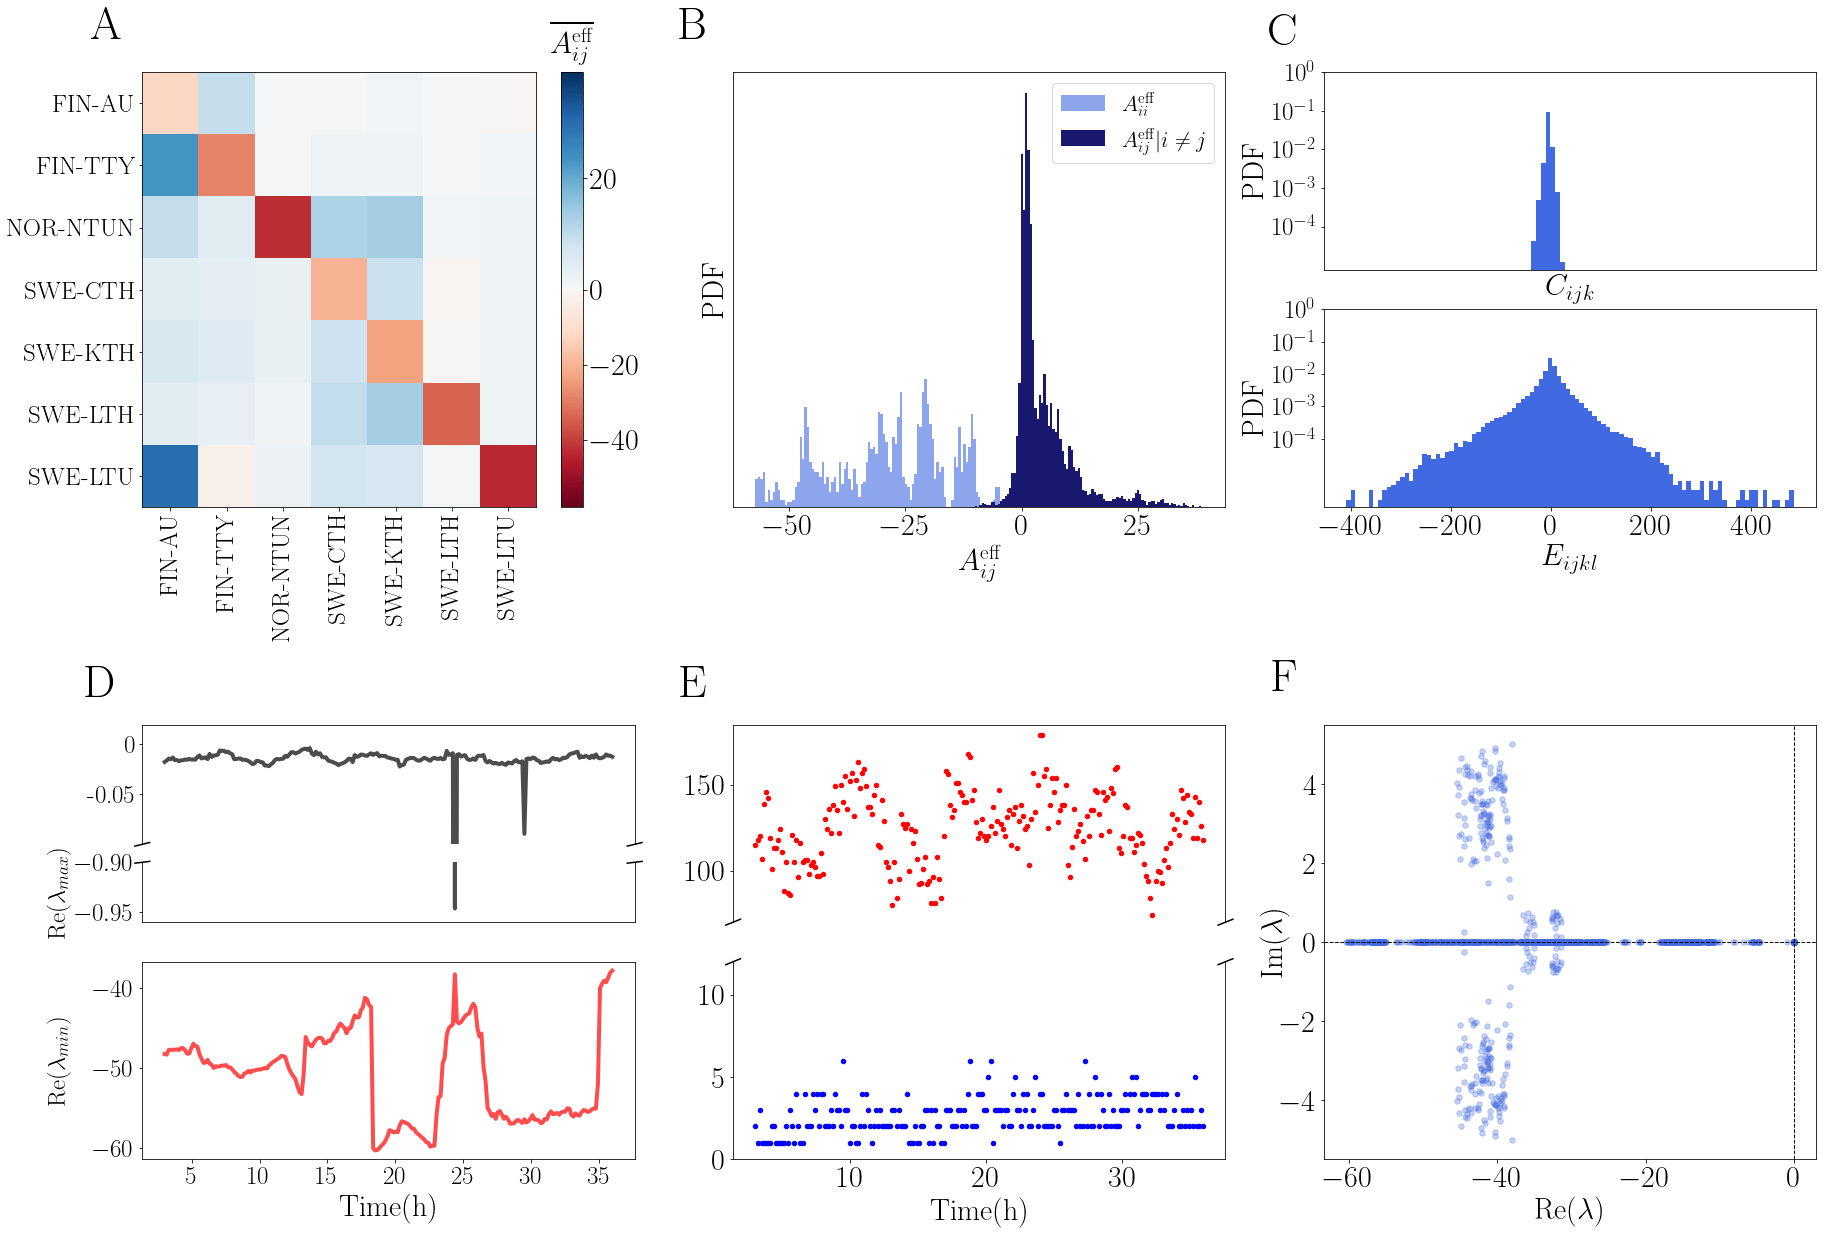

In [14]:
plt.rc('text', usetex=True)
plt.rc('font', **{'family':'Computer Modern','size':20})


panel_label_pos=[-0.1,1.1]
panel_fontsize=46
xy_fontsize=30
legend_fontsize=20


fig = plt.figure(figsize=(30, 20))

main_gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1] , hspace=0.5, wspace=0.1) 
gs_top = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=main_gs[0], height_ratios=[1] , hspace=0.2, wspace=0.2)
gs_bot = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=main_gs[1], height_ratios=[1],  hspace=0.1, wspace=0.2)



# Panel A
####################################################################################################################################
ax1 = fig.add_subplot(gs_top[0, 0])  
Amean=np.mean(EffectiveAdjacency, axis=0)
ticks=np.arange(len(EU7))
ticklist=["FIN-AU","FIN-TTY","NOR-NTUN","SWE-CTH","SWE-KTH","SWE-LTH","SWE-LTU"]
im = ax1.imshow(Amean, aspect='auto', cmap="RdBu", norm=TwoSlopeNorm(vmin=np.min(int(np.min(EffectiveAdjacency))-1), vcenter=0, vmax=np.max(int(np.max(EffectiveAdjacency))+1)))
cbar=fig.colorbar(im, ax=ax1,orientation="vertical") 
cbar.ax.set_title(r'$\overline{A_{ij}^{\mathrm{eff}}}$', fontsize=xy_fontsize,pad=20)
cbar.ax.tick_params(labelsize=xy_fontsize)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ticklist, fontsize=xy_fontsize-5, rotation=90)
ax1.set_yticklabels(ticklist, fontsize=xy_fontsize-5)
ax1.text(panel_label_pos[0]+0.05, panel_label_pos[1]+0.05, 'A', transform=ax1.transAxes, fontsize=panel_fontsize,  va='top', ha='right') 


# Panel B
####################################################################################################################################
ax2 = fig.add_subplot(gs_top[0, 1])
diagonal_elements = []
off_diagonal_elements = []
for matrix in EffectiveAdjacency:
    diagonal_elements.extend(np.diag(matrix))
    off_diagonal_elements.extend(matrix[~np.eye(matrix.shape[0], dtype=bool)])  
ax2.hist(diagonal_elements, color='royalblue', density=True, bins=100, alpha=0.6, label=r'$A_{ii}^{\mathrm{eff}}$')
ax2.hist(off_diagonal_elements, color='midnightblue', density=True, bins=100, alpha=1, label=r'$A_{ij}^{\mathrm{eff}} | i \neq j$')
ax2.set_xlabel(r'$A_{ij}^{\mathrm{eff}}$', fontsize=xy_fontsize)   
ax2.set_ylabel('PDF', fontsize=xy_fontsize)  
ax2.set_yticks([])
ax2.legend(fontsize=22)
ax2.tick_params(axis='x', labelsize=xy_fontsize)
ax2.text(panel_label_pos[0]+0.05, panel_label_pos[1]+0.05, 'B', transform=ax2.transAxes, fontsize=panel_fontsize,  va='top', ha='right')  # fontweight='bold',




# Panel C
####################################################################################################################################
ax3 = fig.add_subplot(gs_top[0, 2])  
gs = ax3.get_gridspec()  
ax3.remove()  
subgs = gs[0,2].subgridspec(2, 1, height_ratios=[1, 1]) 
diagonal_elements = []
off_diagonal_elements = []
i, j, k = np.indices(allb[0].shape)
off_diagonal_mask = (i != j) | (j != k) | (i != k)
for matrix in allb:
    diagonal_elements.extend( np.einsum('iii->i', matrix) )
    off_diagonal_elements.extend(matrix[ off_diagonal_mask ])   
ax_top = fig.add_subplot(subgs[0])
ax_top.hist(allb.flatten(), color='royalblue', density=True, bins=100, range=(np.min(allc), np.max(allc)), alpha=1)
ax_top.set_xlim(np.min(allc), np.max(allc))
ax_top.set_xlabel(r'$C_{ijk}$', fontsize=xy_fontsize, labelpad=5)
ax_top.set_ylabel('PDF', fontsize=xy_fontsize)
ax_top.set_yscale('log')
ax_top.set_yticks([0.0001, 0.001, 0.01, 0.1, 1])
ax_top.set_yticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$"], fontsize=xy_fontsize-15)
ax_top.tick_params(axis='y', labelsize=xy_fontsize-5)
ax_top.set_xticks([]) 


diagonal_elements = []
off_diagonal_elements = []
i, j, k, l = np.indices(allc[0].shape)
off_diagonal_mask = (i != j) | (i != k) | (i != l) | (j != k) | (j != l) | (k != l) 
for matrix in allc:
    diagonal_elements.extend( np.einsum('iiii->i', matrix) )
    off_diagonal_elements.extend(matrix[ off_diagonal_mask ])   
ax_bottom = fig.add_subplot(subgs[1])
ax_bottom.hist(allc.flatten(), color='royalblue', density=True, bins=100, alpha=1)
ax_bottom.set_xlabel(r'$E_{ijkl}$', fontsize=xy_fontsize)
ax_bottom.set_ylabel('PDF', fontsize=xy_fontsize)
ax_bottom.set_yscale('log')
ax_bottom.set_yticks([0.0001, 0.001, 0.01, 0.1, 1])
ax_bottom.set_yticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$"], fontsize=xy_fontsize-15)
ax_bottom.tick_params(axis='y', labelsize=xy_fontsize-5)
ax_bottom.tick_params(axis='x', labelsize=xy_fontsize)

ax_top.text(panel_label_pos[0]+0.05, panel_label_pos[1]+0.2, 'C', transform=ax_top.transAxes, fontsize=panel_fontsize, va='top', ha='right')  





# Panel D: 
####################################################################################################################################

ax4 = fig.add_subplot(gs_bot[0, 0])  
gs = ax4.get_gridspec()  
ax4.remove()  
subgs = gs[0, 0].subgridspec(2, 1, height_ratios=[1, 1]) 
x = np.linspace(540000*0.02/3600,EU7.shape[1]*0.02/3600, 220)




ax_top = fig.add_subplot(subgs[0])

tempgs = ax_top.get_gridspec()
ax_top.remove()
tempsubgs = tempgs[0].subgridspec(2, 1, height_ratios=[2, 1])
ax1 = fig.add_subplot(tempsubgs[0])
ax2 = fig.add_subplot(tempsubgs[1])
ax1.plot(x, ChosenFixedPointRightMostEigenValueReal, color='k', alpha=0.7, linewidth=4)
ax1.set_ylim((-0.10,0.02))
ax1.set_yticks([-0.05, 0], [-0.05, 0])
ax2.plot(x, ChosenFixedPointRightMostEigenValueReal, color='k', alpha=0.7, linewidth=4)
ax2.set_ylim((-0.96,-0.90))
ax2.set_ylabel(r'Re$(\lambda_{max})$', fontsize=25)
ax1.tick_params(axis='y', labelsize=xy_fontsize-5)
ax2.tick_params(axis='y', labelsize=xy_fontsize-5)


ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)  
ax2.xaxis.tick_bottom()
d = .015  
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)      
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs) 
kwargs.update(transform=ax2.transAxes) 
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs) 
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs) 
ax1.set_xticks([]) 
ax2.set_xticks([]) 


ax_bottom = fig.add_subplot(subgs[1])
ax_bottom.plot(x, ChosenFixedPointLeftMostEigenValueReal, color='red', alpha=0.7, linewidth=4) 
ax_bottom.set_xticks([5,10,15,20,25,30,35])
ax_bottom.set_xlabel('Time(h)', fontsize=xy_fontsize, labelpad=5)
ax_bottom.set_ylabel(r'Re$(\lambda_{min})$', fontsize=25)
ax_bottom.tick_params(axis='x', labelsize=xy_fontsize-5)
ax_bottom.tick_params(axis='y', labelsize=xy_fontsize-5)

fig.align_ylabels([ax1, ax2, ax_bottom])
ax1.text(panel_label_pos[0]+0.05, panel_label_pos[1]+0.2, 'D', transform=ax_top.transAxes, fontsize=panel_fontsize, va='top', ha='right')  # fontweight='bold',


# Panel E: 
####################################################################################################################################
ax7 = fig.add_subplot(gs_bot[0, 1]) 
gs = ax7.get_gridspec()  
ax7.remove()  
subgs = gs[0, 1].subgridspec(2, 1, height_ratios=[1, 1]) 
ax1 = fig.add_subplot(subgs[0])
ax2 = fig.add_subplot(subgs[1])
x = np.linspace(540000*0.02/3600,EU7.shape[1]*0.02/3600, 220)
ax1.scatter(x, NumberOfStable_UnstableFixedPoints[:,1], color='red', s=20, alpha=1)
ax2.scatter(x, NumberOfStable_UnstableFixedPoints[:,0], color='blue', s=20)
ax1.tick_params(axis='y', labelsize=xy_fontsize)
ax1.set_ylim(70, 185)  
ax2.set_ylim(0, 12)
ax1.xaxis.set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(True)
ax2.spines['right'].set_visible(True)
d = 0.015 
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  
kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs) 
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  
ax2.set_xlabel('Time(h)', fontsize=xy_fontsize, labelpad=5)
ax2.tick_params(axis='x', labelsize=xy_fontsize)
ax2.tick_params(axis='y', labelsize=xy_fontsize)
ax1.text(panel_label_pos[0]+0.05, panel_label_pos[1]+0.2, 'E', transform=ax1.transAxes, fontsize=panel_fontsize, va='top', ha='right')  





# Panel F: 
####################################################################################################################################
ax6 = fig.add_subplot(gs_bot[0, 2])  
real_parts = []
imaginary_parts = []
for i in range(alleval.shape[0]):
# for i in range(220):
    real_parts.extend(np.real(ChosenFixedPointAllEigenvalues[i]))  
    imaginary_parts.extend(np.imag(ChosenFixedPointAllEigenvalues[i]))  
ax6.scatter(real_parts, imaginary_parts, c='royalblue', alpha=0.3, s=30)
ax6.axhline(0, color='k', linestyle='--', lw=1)  
ax6.axvline(0, color='k', linestyle='--', lw=1)  
ax6.set_xlabel(r'Re$(\lambda)$', fontsize=xy_fontsize)
ax6.set_ylabel(r'Im$(\lambda)$', fontsize=xy_fontsize, labelpad=-10)
ax6.tick_params(axis='x', labelsize=xy_fontsize)
ax6.tick_params(axis='y', labelsize=xy_fontsize)
ax6.text(panel_label_pos[0]+0.05, panel_label_pos[1]+0.05, 'F', transform=ax6.transAxes, fontsize=panel_fontsize,  va='top', ha='right')


plt.show()
